In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
chosen_ramris:str = 'D:\\ESMIRA\\SPSS data\\5. CSA_T1_MRI_scores_SPSS.csv'
df = pd.read_csv(chosen_ramris, sep=';')
WRs = [column for column in df if column[:2]=='WR']
WRs.append('CSANUMM')
dfwr = df[WRs]  # df of wrist + csaid
# 此时获得了所有的WR的列

In [4]:
# 需要计算所有Wrist的TSY, SYN, BME. 合并.1和.2
TSY = [column for column in dfwr if (column[2:5]=='TSY' or column=='CSANUMM')]
SYN = [column for column in dfwr if (column[2:5]=='SYN' or column=='CSANUMM')]
BME = [column for column in dfwr if (column[2:5]=='BME' or column=='CSANUMM')]
dfwr_tsy = df[TSY]
dfwr_syn = df[SYN]
dfwr_bme = df[BME]
# 此时获得了各类的列

In [5]:
def meanreader(df:pd.DataFrame):
    meancolumn = [column[:-2] for column in df if column[-2:]=='.1']
    for col in meancolumn:
        col1, col2 = col+'.1', col+'.2'
        df.loc[:, col1] = pd.to_numeric(df[col1], errors='coerce')
        df.loc[df[col1]>10, col1] = 0
        df.loc[:, col2] = pd.to_numeric(df[col2], errors='coerce')
        df.loc[df[col2]>10, col2] = 0
        df.loc[:, col] = df[[col1, col2]].mean(axis=1, skipna=True)
    leftcolumn = ['CSANUMM']
    leftcolumn.extend(meancolumn)
    return df[leftcolumn]
meantsy = meanreader(dfwr_tsy.copy())
meansyn = meanreader(dfwr_syn.copy())
meanbme = meanreader(dfwr_bme.copy())
# 计算两个rater的平均值

In [6]:
def sumscore(df:pd.DataFrame) ->pd.DataFrame:
    scorecolumn = [column for column in df if column!='CSANUMM']
    df['sums'] = df[scorecolumn].sum(axis=1, skipna=True)
    return df[['CSANUMM', 'sums']]
sumtsy:pd.DataFrame = sumscore(meantsy)  # CSANUMM, sumtsy
sumsyn:pd.DataFrame = sumscore(meansyn)
sumbme:pd.DataFrame = sumscore(meanbme)
# 计算该类炎症的总和值

In [7]:
# 获得预测值-以计算预测误差
def getdiff(feature):
    chosen_ramris:str = f'D:\\ESMIRAcode\\RAMRISinfer\\output\\RAMRISestimation_sum_CSA\\Wrist_{feature}_CSA_sumTrue.csv'
    df = pd.read_csv(chosen_ramris, sep=',')
    print('the column names: ', df.columns)
    # print(df['sums'])
    df['diff'] = df['sums'] - df['sums_gt']
    df['CSANUMM'] = df['ID'].str.slice(3).astype(int)
    return df[['CSANUMM', 'diff']]
# 获得CSANUMM和Diff
difftsy:pd.DataFrame = getdiff('TSY')
diffsyn:pd.DataFrame = getdiff('SYN')
diffbme:pd.DataFrame = getdiff('BME')

the column names:  Index(['Unnamed: 0', 'ID', 'ScanDatum', 'ID_Timepoint', 'sums', 'sums_gt'], dtype='object')
the column names:  Index(['Unnamed: 0', 'ID', 'ScanDatum', 'ID_Timepoint', 'sums', 'sums_gt'], dtype='object')
the column names:  Index(['Unnamed: 0', 'ID', 'ScanDatum', 'ID_Timepoint', 'sums', 'sums_gt'], dtype='object')


In [8]:
#合并两个列表，使得其同时有sum和diff
ultitsy = pd.merge(sumtsy, difftsy, how='inner', on='CSANUMM').drop_duplicates(subset=['CSANUMM'])
ultisyn = pd.merge(sumsyn, diffsyn, how='inner', on='CSANUMM').drop_duplicates(subset=['CSANUMM'])
ultibme = pd.merge(sumbme, diffbme, how='inner', on='CSANUMM').drop_duplicates(subset=['CSANUMM'])
# CSANUMM, sums, diff
print(ultitsy.shape)
print(ultisyn.shape)
print(ultibme.shape)

(716, 3)
(717, 3)
(716, 3)


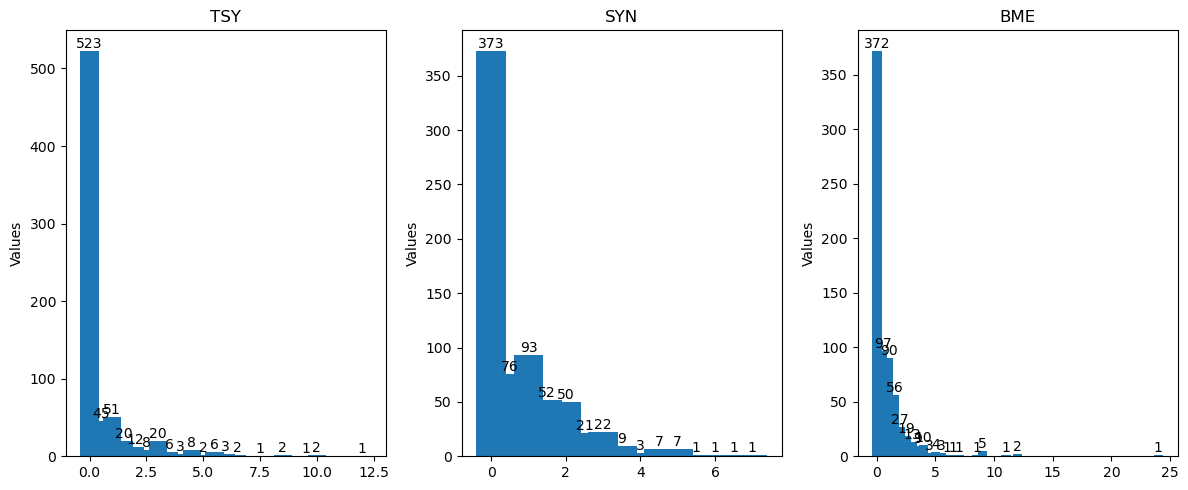

In [9]:
# 看一眼分布情况才能确定后面的bin和bin2
# 看bin
tsycount = ultitsy['sums'].value_counts()
syncount = ultisyn['sums'].value_counts()
bmecount = ultibme['sums'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
bars1 = axs[0].bar(tsycount.index, tsycount.values)
axs[0].set_title('TSY')
axs[0].set_ylabel('Values')
# 在第一个子图上显示每个柱的值
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

bars2 = axs[1].bar(syncount.index, syncount.values)
axs[1].set_title('SYN')
axs[1].set_ylabel('Values')
# 在第二个子图上显示每个柱的值
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

bars3 = axs[2].bar(bmecount.index, bmecount.values)
axs[2].set_title('BME')
axs[2].set_ylabel('Values')
# 在第三个子图上显示每个柱的值
for bar in bars3:
    yval = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')


plt.tight_layout()
plt.show()

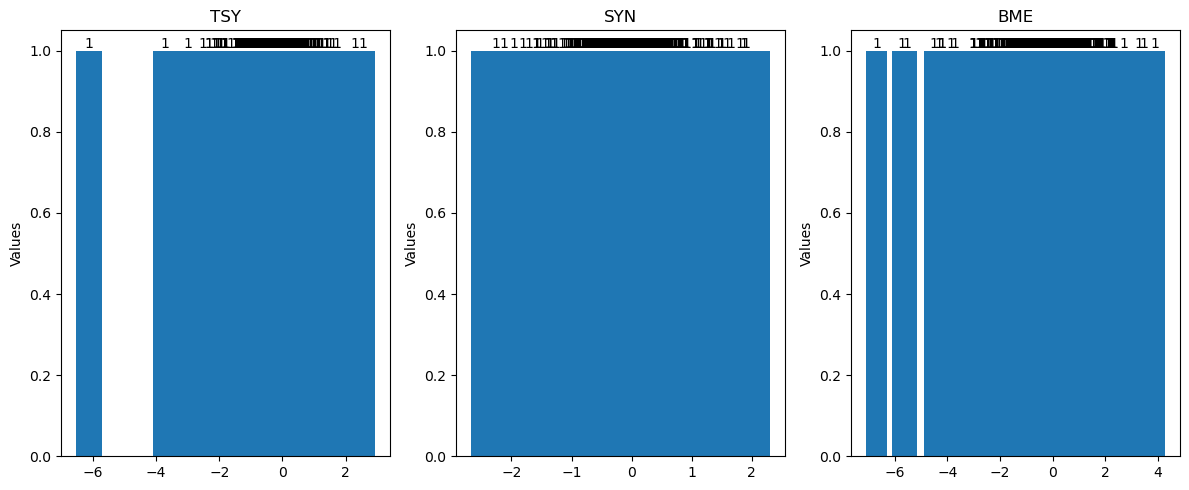

In [10]:
# 看bin2
tsycount = ultitsy['diff'].value_counts()
syncount = ultisyn['diff'].value_counts()
bmecount = ultibme['diff'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
bars1 = axs[0].bar(tsycount.index, tsycount.values)
axs[0].set_title('TSY')
axs[0].set_ylabel('Values')
# 在第一个子图上显示每个柱的值
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

bars2 = axs[1].bar(syncount.index, syncount.values)
axs[1].set_title('SYN')
axs[1].set_ylabel('Values')
# 在第二个子图上显示每个柱的值
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

bars3 = axs[2].bar(bmecount.index, bmecount.values)
axs[2].set_title('BME')
axs[2].set_ylabel('Values')
# 在第三个子图上显示每个柱的值
for bar in bars3:
    yval = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [11]:
# 根据sums和diff的值分别进行分组
# def getsample(df:pd.DataFrame, bin:list, bin2:list, numsample:int=2):
#     # 定义函数，根据分数将数据分组，每2分为一个组
#     df['group1'] = pd.cut(df['sums'], bins=bin, right=False)
#     df['group2'] = pd.cut(df['diff'], bins=bin2, right=False)
#     # 对每个分数区间分组，并在每个组中采样 2 个样本
#     sampled_df = df.groupby(['group1', 'group2'], group_keys=False).apply(lambda x: x.sample(numsample, random_state=42))
#     # 删除 group 分组后的多余层
#     sampled_df = sampled_df.reset_index(drop=True)
#     return sampled_df
# sampletsy = getsample(ultitsy, bin=[0, 1, 2, 4, 12], bin2=[-2, -1, 0, 1, 2], numsample=10)
# samplesyn = getsample(ultisyn, bin=[0, 1, 2, 6], bin2=[-2, -1, 0, 1, 2],umsample=10)
# samplebme = getsample(ultibme, bin=[0, 1, 2, 3, 15], bin2=[-4, -2, 0, 2, 4], numsample=10)

In [12]:
# 以下为三个加一起来看的办法 -- 因为没法同时满足个体和群体都是均匀分布

In [13]:
# 合并三个一起
def merge(df1:pd.DataFrame, df2:pd.DataFrame, df3:pd.DataFrame):
    res = df1.merge(df2, on='CSANUMM', how='inner').merge(df3, on='CSANUMM', how='inner')  # tsy+syn+bme
    return res

res = merge(ultitsy, ultisyn, ultibme).dropna()
print(res.head(10))
print(f'merged: {res.shape}, tsy: {ultitsy.shape}, syn: {ultisyn.shape}, bme: {ultibme.shape}')

   CSANUMM sums_x    diff_x  sums_y    diff_y  sums      diff
0        1    1.0 -0.335315     0.0  0.087895   1.5 -0.528394
1        2    0.5 -0.744817     1.0  0.625907   0.0  2.239243
2        3    0.0  0.243564     0.0 -0.682978   0.5  0.867272
3        4    0.0 -0.619748     0.0 -0.212688   2.5 -0.666709
4        5    0.0  1.087035     2.0  0.401153   4.5 -1.617995
5        6    2.5 -0.735243     0.5  0.651360   0.0  1.592524
6        7    0.0 -0.167440     0.5 -0.466167   0.0  0.468788
7        8    0.5  2.293077     0.5  1.477358   0.0  3.276420
8        9    0.0  0.327149     1.5  0.267843   0.5  0.062696
9       10    0.0 -0.645147     0.0 -0.072712   0.0  0.288471
merged: (715, 7), tsy: (716, 3), syn: (717, 3), bme: (716, 3)


   CSANUMM allsum sums_x  sums_y  sums    alldiff    diff_x    diff_y  \
0        1    2.5    1.0     0.0   1.5  -1.551629 -0.335315  0.087895   
1        2    1.5    0.5     1.0   0.0   4.240665 -0.744817  0.625907   
2        3    0.5    0.0     0.0   0.5   0.855718  0.243564 -0.682978   
3        4    2.5    0.0     0.0   2.5  -2.998289 -0.619748 -0.212688   
4        5    6.5    0.0     2.0   4.5  -0.259615  1.087035  0.401153   
5        6    3.0    2.5     0.5   0.0   3.017282 -0.735243  0.651360   
6        7    0.5    0.0     0.5   0.0  -0.329640 -0.167440 -0.466167   
7        8    1.0    0.5     0.5   0.0  14.093711  2.293077  1.477358   
8        9    2.0    0.0     1.5   0.5   1.315374  0.327149  0.267843   
9       10    0.0    0.0     0.0   0.0  -0.858775 -0.645147 -0.072712   

       diff  
0 -0.528394  
1  2.239243  
2  0.867272  
3 -0.666709  
4 -1.617995  
5  1.592524  
6  0.468788  
7  3.276420  
8  0.062696  
9  0.288471  


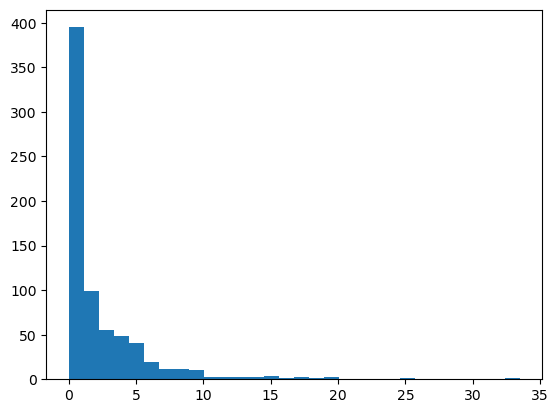

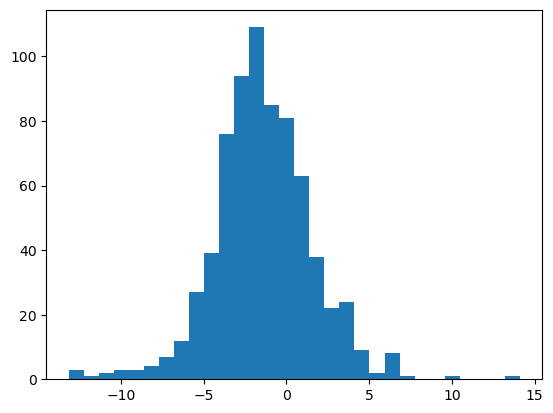

In [15]:
# 看合并之后的bin
def sumreader2(df:pd.DataFrame) ->pd.DataFrame:
    scorecolumn = [column for column in df if 'sums' in column]
    diffcolumn = [column for column in df if 'diff' in column]
    df['allsum'] = df[scorecolumn].sum(axis=1, skipna=True)
    df['alldiff'] = df[diffcolumn].sum(axis=1, skipna=True)
    return df[['CSANUMM', 'allsum', 'sums_x', 'sums_y', 'sums', 'alldiff', 'diff_x', 'diff_y', 'diff']]

res = sumreader2(res)
print(res.head(10))
plt.hist(res.allsum.values, bins=30)
plt.show()
plt.hist(res.alldiff.values, bins=30)
plt.show()

In [19]:
def getsample2(df:pd.DataFrame, bin:list, bin2:list, numsample:int=2):
    # 定义函数，根据分数将数据分组，每2分为一个组
    df['group1'] = pd.cut(df['allsum'], bins=bin, right=False)
    df['group2'] = pd.cut(df['allsum'], bins=bin2, right=False)
    # print(df.head(20))
    # 对每个分数区间分组，并在每个组中采样 2 个样本
    sampled_df = df.groupby(['group1', 'group2'], group_keys=False).apply(lambda x: x.sample(numsample, random_state=42))
    # 删除 group 分组后的多余层
    sampled_df = sampled_df.reset_index(drop=True)
    return sampled_df

item = getsample2(res, bin=[0, 1, 2, 3, 4, 6, 8, 12, 35], bin2=[-5, -4, -3, -2, -1, 0, 1, 2, 5], numsample=20)
print(item.shape)
# print(item.sort_values(by='allsum', ascending=True).head(20))
print(sorted(item.CSANUMM.to_list()))

(100, 11)
[1, 16, 18, 26, 38, 46, 52, 56, 67, 87, 92, 94, 98, 101, 102, 112, 124, 126, 142, 145, 161, 165, 184, 185, 213, 225, 251, 257, 265, 266, 272, 294, 297, 306, 307, 308, 309, 310, 315, 329, 336, 337, 341, 349, 351, 354, 360, 364, 367, 375, 377, 378, 382, 387, 399, 404, 421, 425, 426, 428, 447, 455, 459, 464, 484, 488, 489, 494, 510, 511, 515, 520, 528, 533, 534, 562, 567, 569, 581, 600, 607, 627, 628, 652, 656, 663, 674, 679, 681, 686, 695, 704, 737, 765, 766, 770, 787, 795, 814, 835]


C:\Users\yli5\AppData\Local\Temp\ipykernel_13448\3992111266.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = df.groupby(['group1', 'group2'], group_keys=False).apply(lambda x: x.sample(numsample, random_state=42))
